# Hyperparameter Tuning with GridSearchCV

The [King County Housing Data](https://www.kaggle.com/harlfoxem/housesalesprediction/data) from Kaggle will be used.  The model will predict house price.

Hyperparameters will be optimized.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Prior Notebook Setup
As per [Cross Validation: W and W/O cross_val_score](http://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/king_county/CV_Pipeline.ipynb)

In [2]:
# read king county housing data
parser = lambda date: pd.datetime.strptime(date, '%Y%m%dT%H%M%S')
all_data = pd.read_csv('./data/kc_house_data.csv', parse_dates=['date'], date_parser=parser)

# compute mean sales price per house
mean_price_by_id = all_data.groupby(['id'])['price'].mean()

# convert this to a data frame
mean_price_by_id = pd.DataFrame(mean_price_by_id).reset_index()

# join on id to get a new column for mean price
all_data = all_data.merge(right=mean_price_by_id, on='id', suffixes=['_orig', '_mean'])

# drop original price and de-dup the records
all_data = all_data.drop('price_orig', axis=1).drop_duplicates(subset='id')

# remove id and date fields
all_data = all_data.drop(['id', 'date'], axis=1)

# repace yr_built with yr_renovated if yr_renovated != 0
mask = all_data['yr_renovated'] != 0
all_data.loc[mask, 'yr_built'] = all_data.loc[mask, 'yr_renovated']
all_data = all_data.drop('yr_renovated',axis=1)

all_data = all_data.drop(['zipcode'], axis=1)

X_all = all_data.drop('price_mean', axis=1)
y_all = all_data['price_mean']
print(X_all.shape)
print(y_all.shape)

(21436, 16)
(21436,)


### Hyperparameter Space
The hyperparameter search space will be:

* number of PCA transformed dimensions
* uniform vs distance weighting of K nearest neighbors
* K in KNN

#### PCA Dimensions

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scale = StandardScaler()
pca = PCA()
pca_info = pca.fit(scale.fit_transform(X_all))

In [4]:
np.cumsum(pca_info.explained_variance_ratio_)

array([0.3211265 , 0.44596915, 0.55889199, 0.63903731, 0.70465213,
       0.75889921, 0.80778883, 0.84880948, 0.88731471, 0.91846148,
       0.93968511, 0.95755277, 0.973559  , 0.98770019, 1.        ,
       1.        ])

Text(0.5,1,'Cumulative Variance Explained')

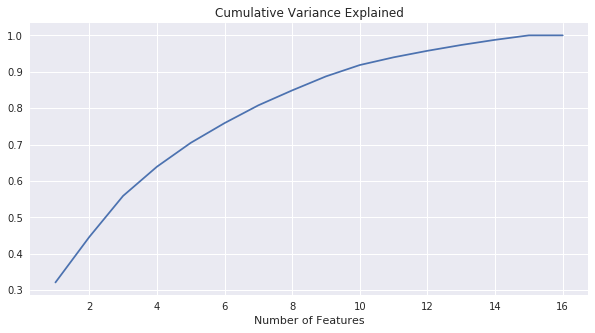

In [5]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,17), np.cumsum(pca_info.explained_variance_ratio_))
plt.xlabel('Number of Features')
plt.title('Cumulative Variance Explained')

At 9 features, we reach about 90% of the variance explained.  Let's try up to 9 features.

In [6]:
# Number of PCA components to try
n_components = list(np.arange(9)+1)
n_components

[1, 2, 3, 4, 5, 6, 7, 8, 9]

#### Uniform vs Distance Weighting
KNN has an option for how it averages the points it finds in nearby space.  'Uniform' means to average the target value (e.g. housing price) of the K closest points as the prediction.  'Distance" means to perform a weighted average of the K closest points where points further away are weighted less.

In [7]:
weights = ['uniform', 'distance']

#### K for KNN

In [8]:
# K in KNN
n_neighbors = [1, 5, 10, 20]
n_neighbors

[1, 5, 10, 20]

#### Hyperparameter Space

In [9]:
param_grid = {
        'pca__n_components': n_components,
        'knn__n_neighbors': n_neighbors,
        'knn__weights':weights
}

### Dask and DASK-ML
Searching through hyperparameter space is time consuming and embarassingly parallel.  Use Dask and DASK-ML to efficient parallelize the computations.  This is optional.

Here Dask will only be used for finding hyperparameters more quickly.  My computing setup is 2 desktop computers, each with 4 physical cores and hyperthreading.  Again, Dask specific commands can be ignored.

In [10]:
# Dask setup
# all commands in this cell can be ignored
import dask_ml.joblib
from sklearn.externals.joblib import parallel_backend
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from dask.distributed import Client
client = Client('192.168.168.67:8786')
client

Client Scheduler: tcp://192.168.168.67:8786 Dashboard: http://192.168.168.67:8787/status,Cluster Workers: 2 Cores: 8 Memory: 67.45 GB


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from time import time

scale = StandardScaler()
pca = PCA()
knn = KNeighborsRegressor()

pipe = Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

# setup an explict cv generator for repeatability
k_folds = 5
random_seed=108
cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

grid = GridSearchCV(pipe, cv=cv, n_jobs=-1, param_grid=param_grid, 
                    scoring='neg_mean_squared_error', verbose=1)

In [12]:
# the only dask command is: with parallel_backend ...
start = time()
with parallel_backend('dask.distributed', scheduler_host='192.168.168.67:8786'):
    grid.fit(X_all, y_all)
    # scores = cross_val_score(grid, X_all, y_all, cv=3)
    
print(f'GridSearchCV Time: {time() - start: 5.1f} seconds')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.5s


GridSearchCV Time:  35.0 seconds


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   34.9s finished


### GridSearchCV Results
The results for the cross validated grid search are stored in grid.cv_results_. As per [Cross Validation: W and W/O cross_val_score](http://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/king_county/CV_Pipeline.ipynb) computing the correct RMSE and standard deviation of the RMSE requires access to the individual cross validated scores.

### Helper Functions to get Data from grid.cv_results
cross_val_score returns an array of values, one per fold.  GridSearchCV does not, however this form easiest to work with.  The following helper functions will reorganize cv_results_ to create a multidimensional array of values.

The dimensions of the array will be:
* K of KFold
* n_components of PCA
* weighting strategy for KNN Regression
* n_neighbors for KNN

In [13]:
# find the dictionary keys to access each CV fold
def get_test_score_keys(grid):
    keys = []
    for key in grid.cv_results_.keys():
        if 'split' in key and 'test' in key:
            keys.append(key)
    return keys

In [14]:
# keys for K fold test scores
get_test_score_keys(grid)

['split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score']

In [15]:
# paramter grid passed in
grid.param_grid

{'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'knn__n_neighbors': [1, 5, 10, 20],
 'knn__weights': ['uniform', 'distance']}

In [16]:
# GridSearchCV places the results in alphabetical order of paramter name
grid.cv_results_['params'][:10]

[{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 1},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 2},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 3},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 4},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 5},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 6},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 7},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 8},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 9},
 {'knn__n_neighbors': 1, 'knn__weights': 'distance', 'pca__n_components': 1}]

In [17]:
# Get the dimensions of the parameter grid
def get_dim(grid):
    dims = []
    for key in sorted(grid.param_grid.keys()):
        dims.append(len(grid.param_grid[key]))
    return tuple(dims)

In [18]:
# dimensions of parameter grid
get_dim(grid)

(4, 2, 9)

These dimensions match what is seen above for grid.cv_results_\['params'\]

In [19]:
# convert the CV test scores to an array
def get_test_data(grid):
    dim = get_dim(grid)
    new_dim = (grid.cv.get_n_splits(), *dim)

    result = np.zeros(new_dim)
    for i, key in enumerate(get_test_score_keys(grid)):
        data = np.array(grid.cv_results_[key])
        data = data.reshape(dim)
        result[i] = data

    return result

In [20]:
# There are 5 (4,2,9) CV test scores
get_test_data(grid).shape

(5, 4, 2, 9)

In [21]:
# verify the helper functions work properly

# compute mean test score using numpy array
test_data = get_test_data(grid)
mean_scores = test_data.mean(axis=0)
print(mean_scores.shape)

# retrieve mean test score from cv_results_
mean_scores2 = grid.cv_results_['mean_test_score']
mean_scores2 = mean_scores2.reshape(get_dim(grid))

# verify that every value is (almost) the same
print(np.allclose(mean_scores, mean_scores2, rtol=2e-5))

(4, 2, 9)
True


Helper methods produced same result.

In [22]:
# verify the helper functions work properly for std as well

test_data = get_test_data(grid)
std_scores = test_data.std(axis=0)
print(std_scores.shape)

std_scores2 = grid.cv_results_['std_test_score']
std_scores2 = std_scores2.reshape(get_dim(grid))
print(np.allclose(std_scores, std_scores2, rtol=6e-5))

(4, 2, 9)
True


As per [Cross Validation: W and W/O cross_val_score](http://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/king_county/CV_Pipeline.ipynb) in the section RMSE Computation.

It is not possible to get RMSE and standard deviation of RMSE, from cv_results_ 'mean_test_score' and 'std_test_score' as these vaules are based on MSE, not RMSE.

In [23]:
# compute RMSE
test_data = get_test_data(grid)
rmse_scores = np.sqrt(np.abs(test_data)).mean(axis=0)

# compute standard deviation of RMSE
std_scores = np.sqrt(np.abs(test_data)).std(axis=0)

### Examine Hyperparameter Space
Create 2 2D arrays, one for each weighting scheme.

Examine each 2D array as heatmap to see where the best model performance is.

In [24]:
# split out the uniformly weighted from the distance weighted mean of the K target values
rmse_uniform = rmse_scores[:,0,:]
rmse_dist    = rmse_scores[:,1,:]
std_uniform   = std_scores[:,0,:]
std_dist      = std_scores[:,1,:]
print(rmse_uniform.shape)

(4, 9)


Text(0.5,1,'RMSE Uniform Weighting')

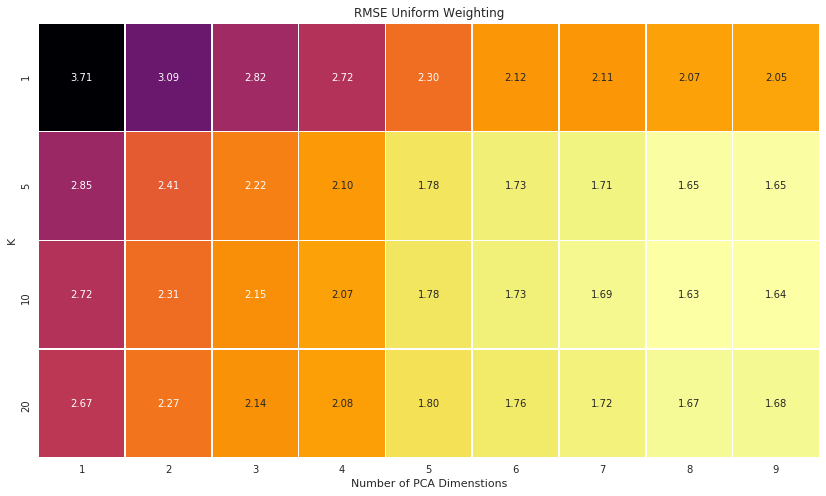

In [25]:
# scale so annotation on plot is more readable
df = pd.DataFrame(data=rmse_uniform/1e5, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('RMSE Uniform Weighting')

Text(0.5,1,'RMSE Distance Weighting')

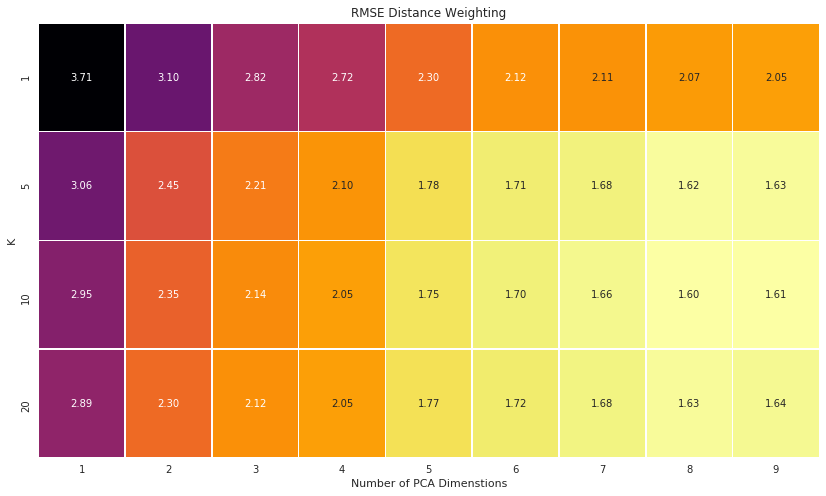

In [26]:
# scale so annotation on plot is more readable
df = pd.DataFrame(data=rmse_dist/1e5, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('RMSE Distance Weighting')

Text(0.5,1,'Standard Devation of RMSE Uniform Weighting')

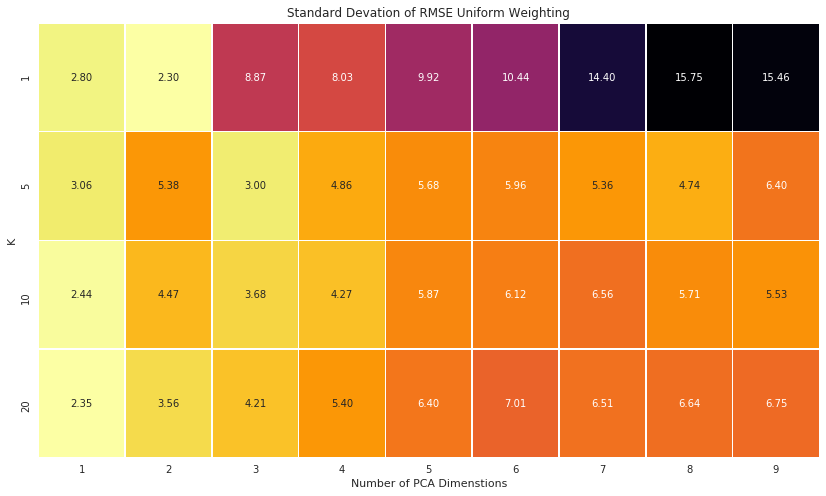

In [27]:
# scale to annotation on plot is more readable
df = pd.DataFrame(data=std_uniform/1e3, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('Standard Devation of RMSE Uniform Weighting')

Text(0.5,1,'Standard Devation of RMSE Distance Weighting')

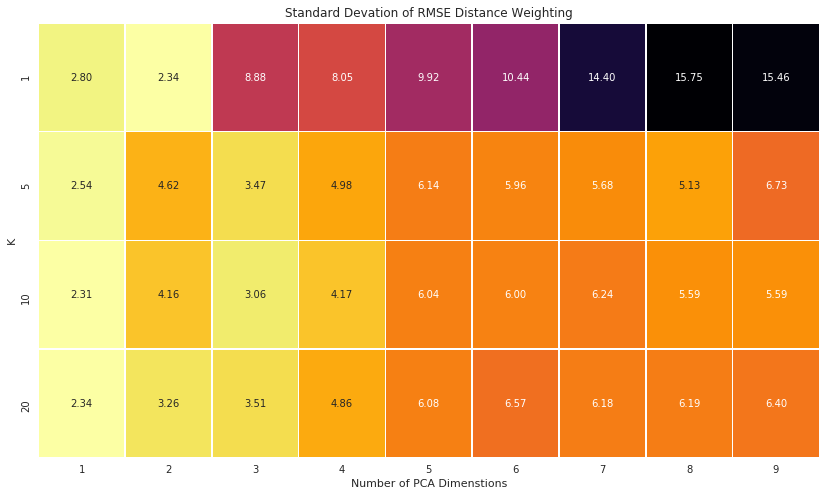

In [28]:
# scale to annotation on plot is more readable
df = pd.DataFrame(data=std_dist/1e3, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('Standard Devation of RMSE Distance Weighting')

Best score was (10, distance, 8).  Compute these again with cross_val_score() to verify results.

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

scale = StandardScaler()
pca = PCA(n_components=8)
knn = KNeighborsRegressor(weights='distance', n_neighbors=10)

pipe = Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

# setup an explict cv generator for repeatability
k_folds = 5
random_seed=108
cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

# with parallel_backend('dask.distributed', scheduler_host='192.168.168.67:8786'):
scores = cross_val_score(pipe, X_all, y_all, cv=cv, 
                             scoring='neg_mean_squared_error', n_jobs=1)

# RMSE
rmse = np.sqrt(np.abs(scores)).mean()
rmse

160024.18177278718

In [30]:
# verify the rmse scores computed above match
print(grid.param_grid['knn__n_neighbors'][2])
print(grid.param_grid['knn__weights'][1])
print(grid.param_grid['pca__n_components'][7])

# RMSE for K = 10, weight = distance, PCA components = 8
rmse_scores[2,1,7]
print(np.allclose(rmse, rmse_scores[2,1,7]))

10
distance
8
True


### Analysis of Results
Put that here ...
Refere to LearningCurve and BiasCorrection nb